In [ ]:
!pip install pyyaml==5.1
!pip install torch==1.9.0+cu102 torchvision==0.10.0+cu102 -f https://download.pytorch.org/whl/torch_stable.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.9/index.html
# Инструкции https://detectron2.readthedocs.io/tutorials/install.html 

## Начало

In [ ]:
# Проверка версий
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
assert torch.__version__.startswith("1.9") 

In [2]:
# Устанавливаем логгер для детектрона
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# Импорты
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

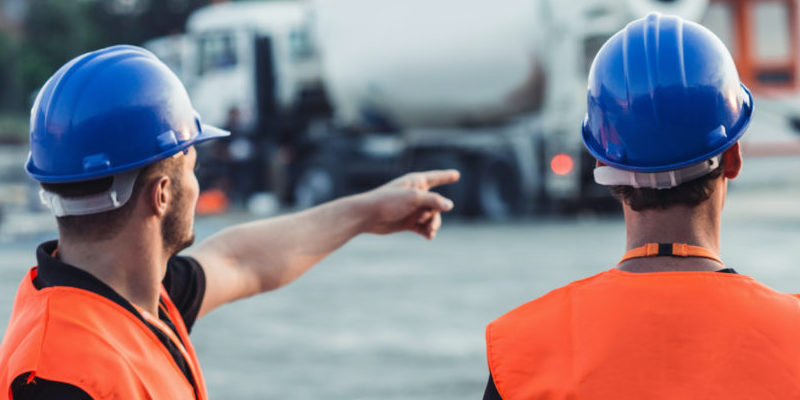

In [3]:
!wget https://www.ppeindustrialsupplies.co.uk/IMG/arton122.jpg?1604933695 -q -O input1.jpg
hat_im = cv2.imread("./input1.jpg")
cv2_imshow(hat_im)

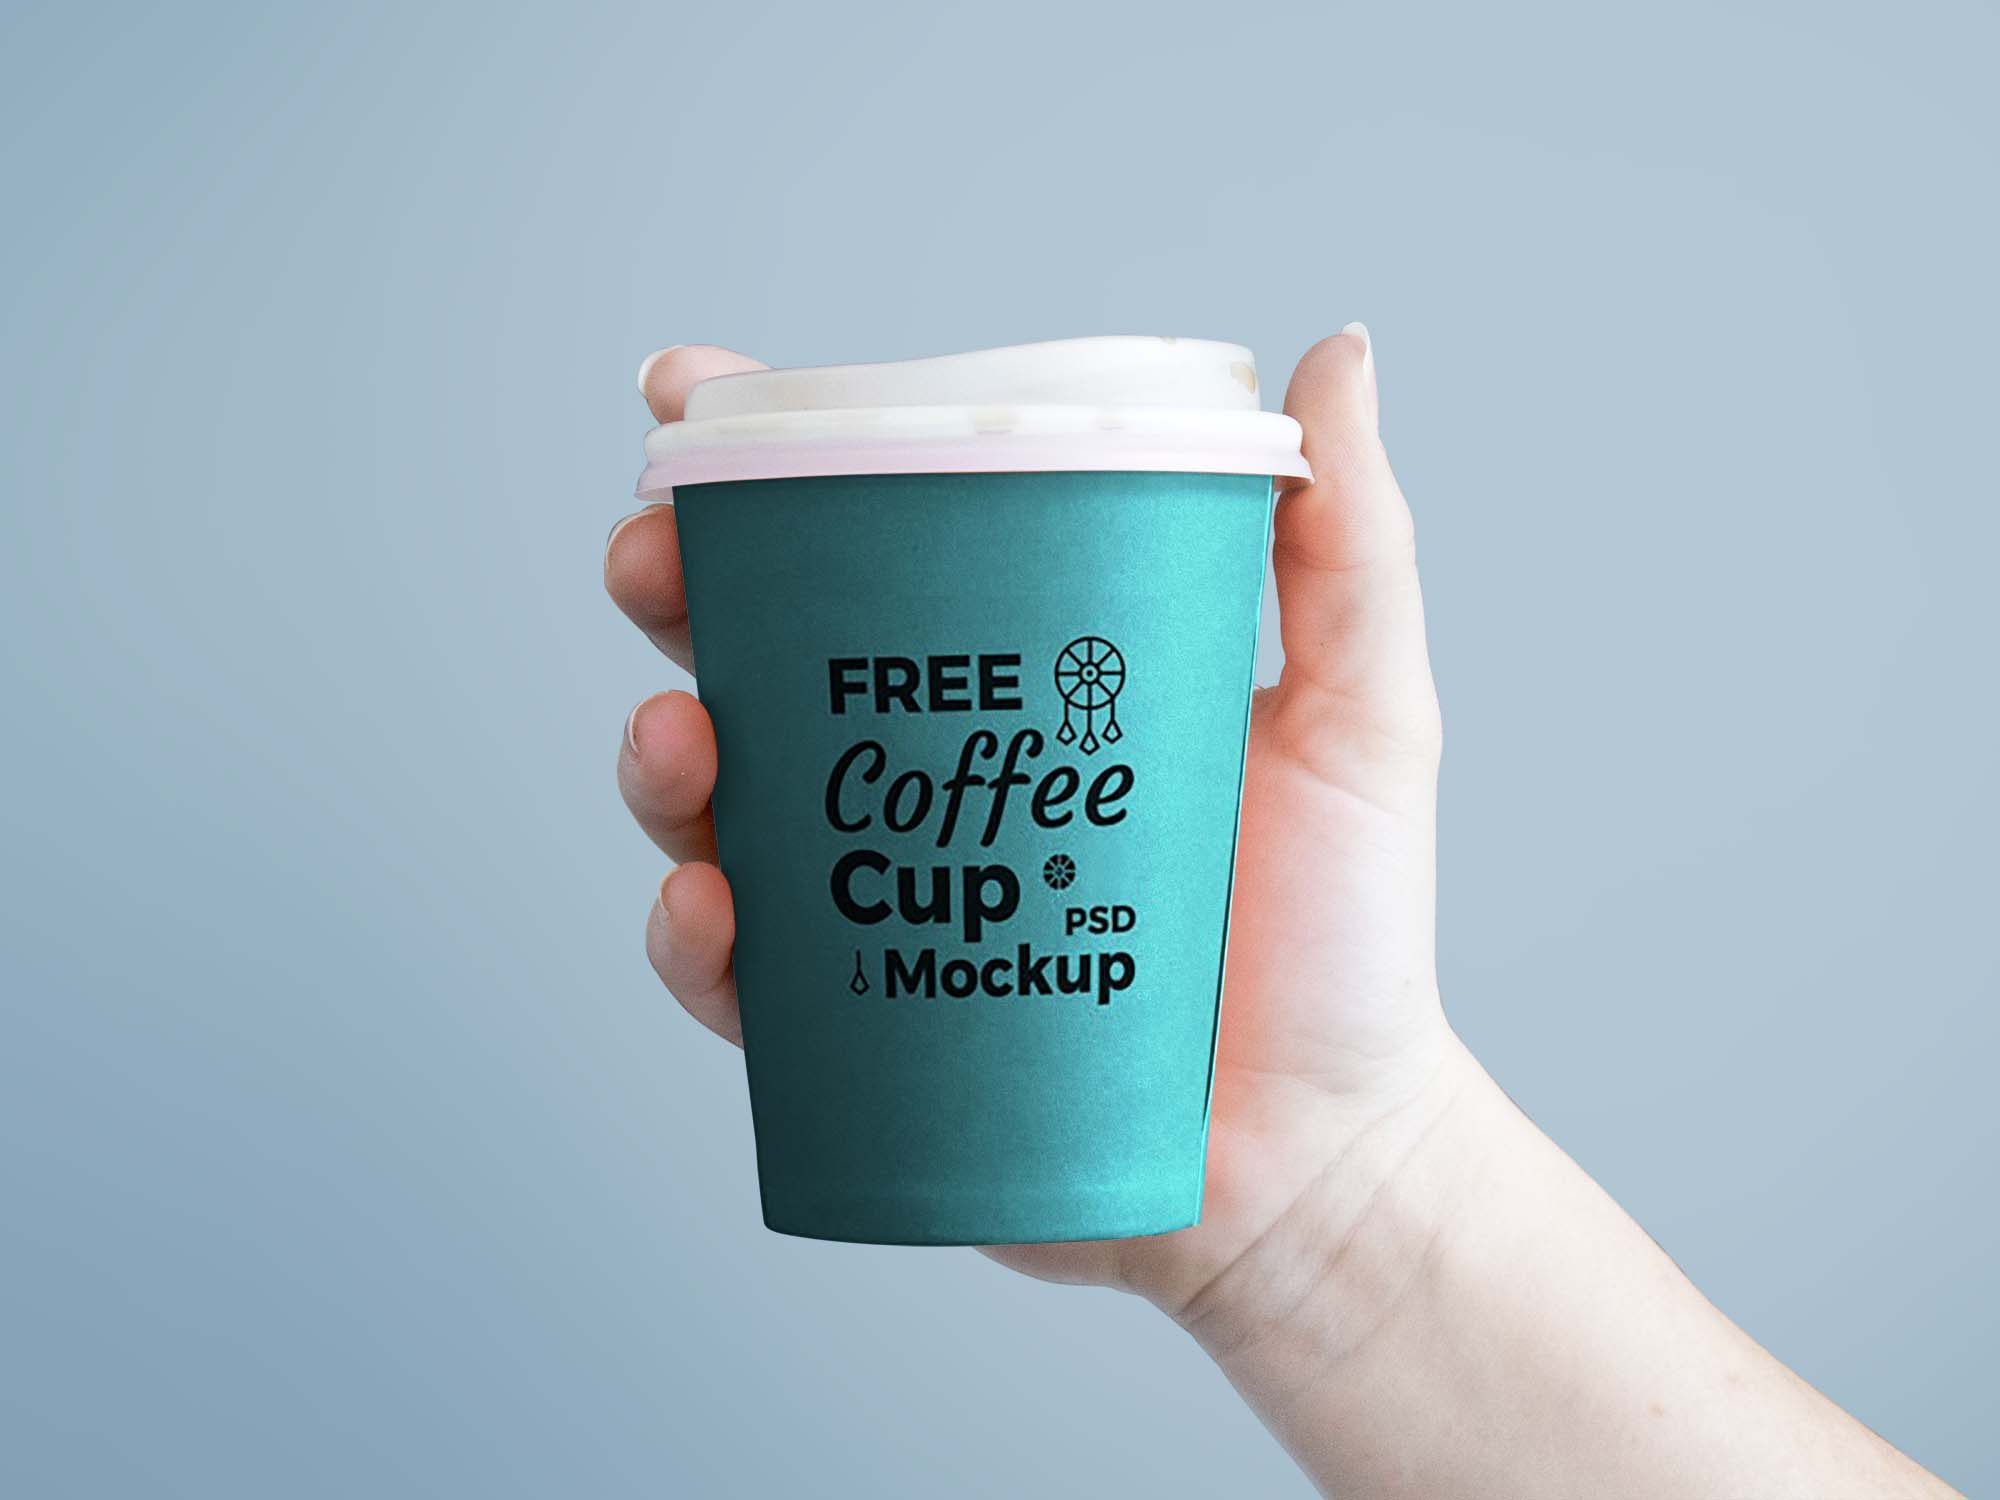

In [4]:
# Загружаем картинку и распечатываем
!wget https://unblast.com/wp-content/uploads/2020/08/Coffee-Cup-Hand-Mockup-1.jpg -q -O input2.jpg
cup_im = cv2.imread("./input2.jpg")
cv2_imshow(cup_im)

## Детекция

### Простой инференс с FASTER RCNN R-50

In [30]:
# Используем дефолтный конфиг
cfg = get_cfg()
# Загружаем конфиг для модели MASK RCNN R 50 # COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_1x.yaml"))
# Устанавливаем порог для детекции: если уровень доверия меньше порога, детекция не состоится
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
# Загружаем модель
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_1x.yaml")
# Создаем объект предиктора
predictor = DefaultPredictor(cfg)

In [31]:
# Передаем в объект загруженное выше изображение
outputs = predictor(cup_im)

In [ ]:
outputs['instances']

Instances(num_instances=2, image_height=1500, image_width=2000, fields=[pred_boxes: Boxes(tensor([[ 621.9787,  338.2673, 1974.4919, 1488.8665],
        [ 611.3798,  348.2794, 1324.8157, 1240.9088]], device='cuda:0')), scores: tensor([0.9946, 0.9801], device='cuda:0'), pred_classes: tensor([ 0, 41], device='cuda:0')])

In [ ]:
outputs['instances'].pred_boxes

Boxes(tensor([[ 621.9787,  338.2673, 1974.4919, 1488.8665],
        [ 611.3798,  348.2794, 1324.8157, 1240.9088]], device='cuda:0'))

In [ ]:
cup_im.shape

(1500, 2000, 3)

In [32]:
cfg.DATASETS.TRAIN

('coco_2017_train',)

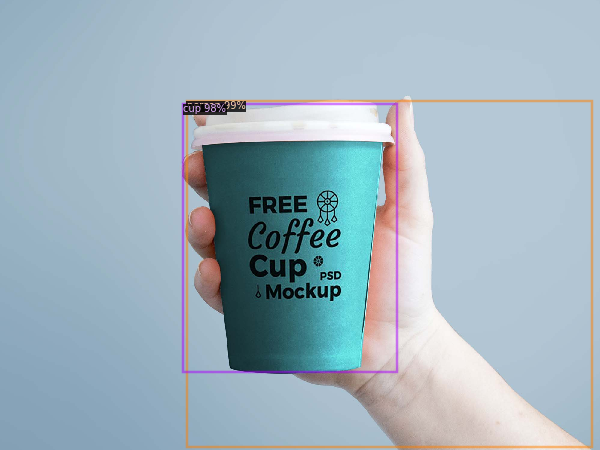

In [33]:
# Визуализируем  
v = Visualizer(cup_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.3)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
# Передаем в объект загруженное выше изображение
outputs = predictor(hat_im)

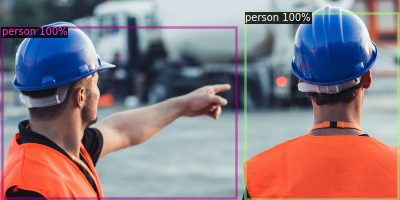

In [ ]:
# Визуализируем  
v = Visualizer(hat_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.5)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

## Сегментация

### Простой инференс с MASK RCNN R-50

In [34]:
# Используем дефолтный конфиг
cfg = get_cfg()
# Загружаем конфиг для модели MASK RCNN R 50 # COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml"))
# Устанавливаем порог для детекции: если уровень доверия меньше порога, детекция не состоится
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7
# Загружаем модель
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml")
# Создаем объект предиктора
predictor = DefaultPredictor(cfg)

In [35]:
# Передаем в объект изображение чашки
outputs = predictor(cup_im)

In [24]:
outputs['instances']

Instances(num_instances=0, image_height=1500, image_width=2000, fields=[pred_boxes: Boxes(tensor([], device='cuda:0', size=(0, 4))), scores: tensor([], device='cuda:0'), pred_classes: tensor([], device='cuda:0', dtype=torch.int64), pred_masks: tensor([], device='cuda:0', size=(0, 1500, 2000), dtype=torch.bool)])

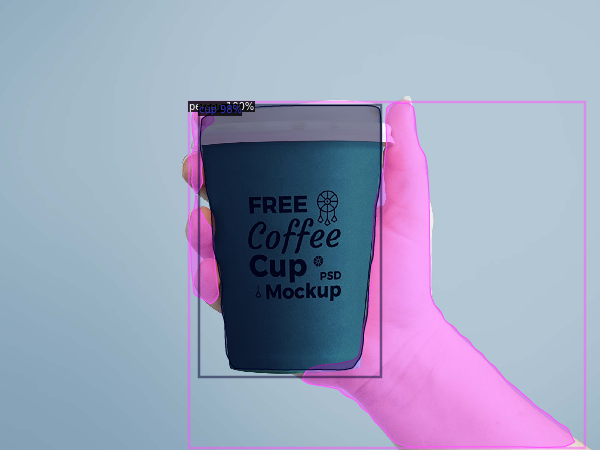

In [36]:
# Визуализируем  
v = Visualizer(cup_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.3)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [37]:
# Передаем в объект изображение шлема
outputs = predictor(hat_im)

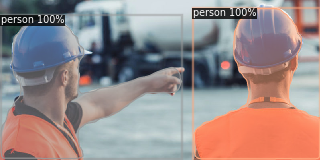

In [38]:
# Визуализируем  
v = Visualizer(hat_im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.4)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

## Обучение на своих данных

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
# Загружаем датасет с самолетами
!unzip -qq /content/drive/MyDrive/Hard_Hat.coco.zip

In [ ]:
# Структура датасета: 

# |dataset_name
# |--train
# |----filename.jpg
# |----filename.jpg
# |----annotations.json
# |--valid
# |----filename.jpg
# |----filename.jpg
# |----annotations.json
# |--test
# |----filename.jpg
# |----filename.jpg
# |----annotations.json

In [11]:
## регистрация собственных датасетов
from detectron2.data.datasets import register_coco_instances
register_coco_instances("hat_train", {}, 
                        "Hard_Hat.coco/train/_annotations.coco.json", 
                        "Hard_Hat.coco/train/")
## Сохранение данных для работы сети
hats_metadata = MetadataCatalog.get("hat_train")
hats_dicts = DatasetCatalog.get("hat_train")
## ЕСЛИ У ВАС НЕСКОЛЬКО ЧАСТЕЙ ДАТАСЕТА: TRAIN, VALID, TEST – их ВСЕ нужно зарегистрировать 
## НАПРИМЕР:
register_coco_instances("hat_valid", {}, 
                        "Hard_Hat.coco/valid/_annotations.coco.json", 
                        "Hard_Hat.coco/valid/")
register_coco_instances("hat_test", {}, 
                        "Hard_Hat.coco/test/_annotations.coco.json", 
                        "Hard_Hat.coco/test/")
hats_metadata = MetadataCatalog.get("hat_valid")
hats_dicts = DatasetCatalog.get("hat_valid")
hats_metadata = MetadataCatalog.get("hat_test")
hats_dicts = DatasetCatalog.get("hat_test")

WARNING [11/10 12:30:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/10 12:30:24 d2.data.datasets.coco]: Loaded 210 images in COCO format from Hard_Hat.coco/train/_annotations.coco.json
WARNING [11/10 12:30:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/10 12:30:24 d2.data.datasets.coco]: Loaded 20 images in COCO format from Hard_Hat.coco/valid/_annotations.coco.json
WARNING [11/10 12:30:24 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/10 12:30:24 d2.data.datasets.coco]: Loaded 10 images in COCO format from Hard_Hat.coco/test/_annotations.coco.json


In [12]:
hats_metadata.thing_classes

['Workers', 'head', 'helmet', 'person']

In [13]:
from detectron2.engine import DefaultTrainer
# ПАРАМЕТРЫ ОБУЧЕНИЯ
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_DC5_1x.yaml"))
cfg.DATASETS.TRAIN = ("hat_train",)
cfg.DATASETS.VALID = ("hat_valid",)
cfg.DATASETS.TEST = ()
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_DC5_1x.yaml") 
cfg.SOLVER.IMS_PER_BATCH = 3
cfg.SOLVER.BASE_LR = 0.0025  # learning_rate
cfg.SOLVER.MAX_ITER = 1000    # число итераций
cfg.SOLVER.STEPS = []        # do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # batch_size
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # число классов: в нашем датасете единственный (see https://detectron2.readthedocs.io/tutorials/datasets.html#update-the-config-for-new-datasets)
####################
# Запускаем обучение
## Проверяем, существует ли папка для сохранения обученной модели
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
## Создаем объект "тренировщика" 
trainer = DefaultTrainer(cfg) 
## Запускаем обучение заново -≥ resume=False
trainer.resume_or_load(resume=False)
## Запускаем обучение
trainer.train()

[11/10 12:30:47 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): ResNet(
    (stem): BasicStem(
      (conv1): Conv2d(
        3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
        (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
      )
    )
    (res2): Sequential(
      (0): BottleneckBlock(
        (shortcut): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
        )
        (conv1): Conv2d(
          64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv2): Conv2d(
          64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
        (conv3): Conv2d(
          64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False
          (norm): FrozenBatchNorm2d(num_features=256, eps=1e-05)
 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
model_final_51d356.pkl: 663MB [00:12, 51.9MB/s]                          
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[11/10 12:31:05 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[11/10 12:31:21 d2.utils.events]:  eta: 0:12:48  iter: 19  total_loss: 2.493  loss_cls: 1.585  loss_box_reg: 0.6467  loss_rpn_cls: 0.256  loss_rpn_loc: 0.028  time: 0.7477  data_time: 0.0415  lr: 4.9952e-05  max_mem: 4078M
[11/10 12:31:35 d2.utils.events]:  eta: 0:10:55  iter: 39  total_loss: 2.066  loss_cls: 1.023  loss_box_reg: 0.687  loss_rpn_cls: 0.2113  loss_rpn_loc: 0.02388  time: 0.7269  data_time: 0.0173  lr: 9.9902e-05  max_mem: 4078M
[11/10 12:31:50 d2.utils.events]:  eta: 0:10:54  iter: 59  total_loss: 1.403  loss_cls: 0.5881  loss_box_reg: 0.6759  loss_rpn_cls: 0.1165  loss_rpn_loc: 0.02667  time: 0.7331  data_time: 0.0186  lr: 0.00014985  max_mem: 4078M
[11/10 12:32:05 d2.utils.events]:  eta: 0:10:48  iter: 79  total_loss: 1.402  loss_cls: 0.4816  loss_box_reg: 0.7615  loss_rpn_cls: 0.1109  loss_rpn_loc: 0.02551  time: 0.7371  data_time: 0.0195  lr: 0.0001998  max_mem: 4078M
[11/10 12:32:20 d2.utils.events]:  eta: 0:10:35  iter: 99  total_loss: 1.241  loss_cls: 0.3391  los

In [16]:
# Подгружаем обученную модель
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # путь к обученной модели
# устанавливаем порог обнаружения
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.9
# создаем объект для построения предсказаний
predictor_educated = DefaultPredictor(cfg)

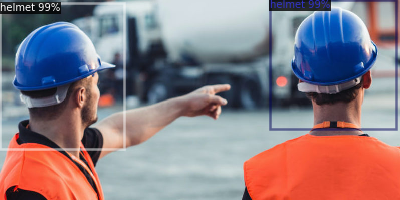

In [18]:
# Визуализируем
outputs = predictor_educated(hat_im)
v = Visualizer(hat_im[:, :, ::-1],
                   metadata=hats_metadata, 
                   scale=0.5
    )
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [19]:
# Смотрим изображения из тестовой выборки
test_path = "/content/Hard_Hat.coco/test"
for i, f in enumerate(sorted(os.listdir(test_path))):
    if f!='_annotations.coco.json':
        file = test_path + '/' + f
        im = cv2.imread(file)
        outputs = predictor_educated(im)
        v = Visualizer(im[:, :, ::-1], 
                   metadata=hats_metadata, 
                   scale=1.2
        )
        out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
        cv2_imshow(out.get_image())
        filename = '/content/Hard_Hat.coco' + '/' + f
        cv2.imwrite(filename, out.get_image())

Output hidden; open in https://colab.research.google.com to view.

In [17]:
# Смотрим метрики
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("hat_valid", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "hat_valid")
print(inference_on_dataset(predictor_educated.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [11/10 12:51:34 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/10 12:51:34 d2.data.datasets.coco]: Loaded 20 images in COCO format from Hard_Hat.coco/valid/_annotations.coco.json
[11/10 12:51:34 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[11/10 12:51:34 d2.data.common]: Serializing 20 elements to byte tensors and concatenating them all ...
[11/10 12:51:34 d2.data.common]: Serialized dataset takes 0.01 MiB
[11/10 12:51:34 d2.evaluation.evaluator]: Start inference on 20 batches


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


[11/10 12:51:36 d2.evaluation.evaluator]: Inference done 11/20. Dataloading: 0.0011 s/iter. Inference: 0.1645 s/iter. Eval: 0.0002 s/iter. Total: 0.1658 s/iter. ETA=0:00:01
[11/10 12:51:38 d2.evaluation.evaluator]: Total inference time: 0:00:02.652938 (0.176863 s / iter per device, on 1 devices)
[11/10 12:51:38 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:02 (0.163888 s / iter per device, on 1 devices)
[11/10 12:51:38 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/10 12:51:38 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[11/10 12:51:38 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[11/10 12:51:38 d2.evaluation.fast_eval_api]: Evaluate annotation type *bbox*
[11/10 12:51:38 d2.evaluation.fast_eval_api]: COCOeval_opt.evaluate() finished in 0.01 seconds.
[11/10 12:51:38 d2.evaluation.